In [ ]:
import specsuite as ss

# Standard information used for loading data
CAL_PATH = "../data/KOSMOS/calibrations"
DATA_PATH = "../data/KOSMOS/target"
INSTRUMENT = "kosmos"

# The rows in which each trace is found
trace_regions = [
    (180, 280),
    (700, 800),
]

# The rows in sub-images that are contaminated by the trace
mask_regions = [
    (35, 65),
    (40, 80)
]

vmin, vmax = (1e2, 5e3)

# Runs for both traces (one signal, one comparison star)
for REGION in trace_regions:

    # Loads standard calibration images into a single, averaged Numpy array
    bias = ss.average_matching_files(CAL_PATH, "bias", crop_bds=REGION, instrument=INSTRUMENT)
    flat = ss.average_matching_files(CAL_PATH, "flat", crop_bds=REGION, instrument=INSTRUMENT) - bias
    neon = ss.average_matching_files(CAL_PATH, "neon", crop_bds=REGION, instrument=INSTRUMENT) - bias
    data = ss.average_matching_files(DATA_PATH, "toi3884", crop_bds=REGION, instrument=INSTRUMENT) - bias

    # Performs a flatfield correction to both 'data' and 'arclamp' exposures
    neon = ss.flatfield_correction(neon, flat)
    data = ss.flatfield_correction(data, flat)

    # Generates "warp model" using the neon arclamp image
    line_locations, _ = ss.find_cal_lines(neon, std_variation=30)
    warp_model = ss.generate_warp_model(neon, line_locations)

    # Extracts and subtracts background emissions
    backgrounds = ss.extract_background(data, warp_model, update=True)[0]
    data -= backgrounds

Extracting Background: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


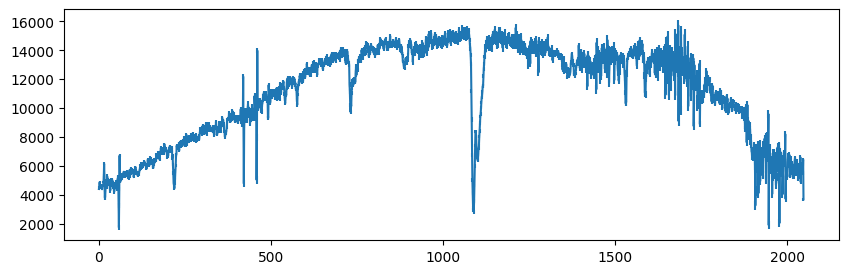

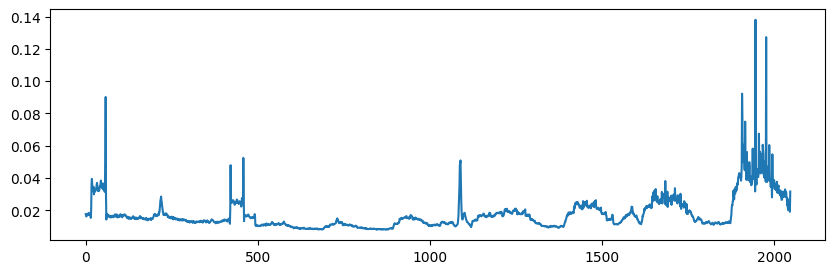

In [57]:
import numpy as np
import matplotlib.pyplot as plt

def boxcar_extraction(images, backgrounds, RN=0):

    if len(images) != 3:
        images = np.array([images])
    if len(backgrounds) != 3:
        backgrounds = np.array([backgrounds])

    flux = np.sum(images, axis=1)
    errs = np.sqrt(np.sum(backgrounds, axis=1) + RN**2)

    for spectra, err in zip(flux, errs):
        xs = np.array(range(len(spectra)))
        plt.errorbar(xs, spectra, yerr=err)
        plt.show()
        plt.plot(xs, err/spectra)
        plt.show()

boxcar_extraction(data, backgrounds, RN=6)